In [1]:
import pandas as pd  # For dataframe
import numpy as np  # For matrix operations
import sklearn.preprocessing as sklpre  # For preprocessing (scaling)
import sklearn.linear_model as skllm  # For OLS
import sklearn.model_selection as sklms  # For train_test_split
from scipy import stats  # To calc p-value
import matplotlib.pyplot as plt  # For plotting
import pygam  # For generalized additive models
import sklearn.ensemble as sklen  # For ensemble methods
import sklearn.neighbors as sklne # for 

# For automatic formatting of code, sparing you from my usually horrible looking code
%load_ext nb_black

<IPython.core.display.Javascript object>

# Task 1.1
I have chosen to one-hot encode the SEX-category, as neither male nor female should be considered adifferent numbers. 
The rest of the categorical values are just true/false, so those aren't encoded. 
Then I scale all the scalar features, not touching the categorical features.

In [4]:
# Reading the data into dataframe
df = pd.read_csv("data_task_1.txt", header=0, sep=" ")
# Onehot-encoding gender
onehot_gender = pd.get_dummies(df["SEX"]).set_axis(
    ["Male", "Female"], axis=1, inplace=False
)
# Replacing old gender column
df = df.join(onehot_gender)
df.drop("SEX", axis=1, inplace=True)
# List of boolean categories
categorical = [
    "ADHEU",
    "HOCHOZON",
    "AMATOP",
    "AVATOP",
    "ADEKZ",
    "ARAUCH",
    "FSNIGHT",
    "FSPT",
    "FSATEM",
    "FSAUGE",
    "FSPFEI",
    "FSHLAUF",
    "Male",
    "Female",
]

# A loop that splits the data and tries again until there is no split where only one modality is in one split
first = True
while (
    first
    or np.any(
        np.logical_or(X_train.sum(axis=0) == 0, X_train.sum(axis=0) == X_train.shape[0])
    )
    or np.any(
        np.logical_or(X_test.sum(axis=0) == 0, X_test.sum(axis=0) == X_test.shape[0])
    )
):
    first = False
    # Splitting over and over until splits are good, stratifying the most biased feature.
    X_train, X_test, y_train, y_test = sklms.train_test_split(
        df.loc[:, df.columns != "FFVC"],
        df["FFVC"],
        test_size=0.5,
        stratify=df["FSATEM"],
    )
# Scaling scalar features based on train set
scaler = sklpre.StandardScaler()
X_train_continous = scaler.fit_transform(
    X_train.loc[:, np.logical_not(np.isin(X_train.columns, categorical))].values
)
X_test_continous = scaler.transform(
    X_test.loc[:, np.logical_not(np.isin(X_test.columns, categorical))].values
)
# Putting all scalar and categorical features together
X_train.loc[
    :, np.logical_not(np.isin(X_train.columns, categorical))
] = X_train_continous
X_test.loc[:, np.logical_not(np.isin(X_test.columns, categorical))] = X_test_continous
# Need to specify datatypes because it chose a dumb datatype by default
X_train = X_train.astype({"Male": "int32", "Female": "int32"})
X_test = X_test.astype({"Male": "int32", "Female": "int32"})
# All preprocessing done!

<IPython.core.display.Javascript object>

# Task 1.2
Running OLS, calculating uncertainties and p-values

In [3]:
%load_ext rpy2.ipython
train_for_r = X_train.join(y_train)
test_for_r = X_test.join(y_test)

<IPython.core.display.Javascript object>

In [4]:
# OLS on train data
ols_reg = skllm.LinearRegression().fit(X_train, y_train)
# R2 score
r2 = ols_reg.score(X_test, y_test)
coeffs_table = get_summary_linear_model(ols_reg, X_train, y_train)
most_important = coeffs_table["Feature"].values[1:][
    np.argmin(coeffs_table["p-values"].values[1:])
]
# Printing results
print(f"Got an R^2 score of {r2:.2f} for the test set.")
print(f"The most important feature (lowest p-value) is {most_important}.")
coeffs_table

Got an R^2 score of 0.59 for the test set.
The most important feature (lowest p-value) is FLGROSS.


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.346831,0.026624,0.000000e+00
1,ALTER,0.004857,0.017255,7.785705e-01
2,ADHEU,-0.145300,0.080722,7.308164e-02
3,HOCHOZON,-0.053635,0.041230,1.945075e-01
4,AMATOP,-0.047637,0.037801,2.087844e-01
5,AVATOP,-0.044020,0.036559,2.297168e-01
6,ADEKZ,0.061384,0.037673,1.045070e-01
7,ARAUCH,0.013920,0.033134,6.747662e-01
8,AGEBGEW,0.006542,0.015020,6.635539e-01
9,FSNIGHT,0.017598,0.051710,7.339054e-01


<IPython.core.display.Javascript object>

The most important (lower p-value) feature seems to be FLGROSS. Some other important features seem to be gender. Male and female seem to completely cancel each other, implying that men are of higher risk?

# Task 1.3
Scikit-learn for some reason doesn't have built in forward and backward selection, so I will create my own functions!

In [5]:
%load_ext rpy2.ipython
train_for_r = X_train.join(y_train)
test_for_r = X_test.join(y_test)

<IPython.core.display.Javascript object>

In [6]:
# Using R only for the lines with %R.
%R library(mlbench)
# Loading dataframe
%R data(PimaIndiansDiabetes)
# Now saving the dataframe in a Pandas dataframe in Python instead.
# This is actually really cool, just found out how to do it. Using
# Python together with R this way is probably very useful in data science!
df_2 = %R PimaIndiansDiabetes
X_2 = df_2.loc[:, df_2.columns != "diabetes"]
y_2 = df_2["diabetes"]
y_2 = (y_2.values == "neg").astype(np.int)
y_2 = pd.DataFrame(y_2, columns=["diabetes"])
X_train_2, X_test_2, y_train_2, y_test_2 = sklms.train_test_split(
    X_2, y_2, stratify=y_2, test_size=0.33
)
scaler_2 = sklpre.StandardScaler()
X_train_2 = pd.DataFrame(scaler_2.fit_transform(X_train_2), columns=X_train_2.columns)
X_test_2 = pd.DataFrame(scaler_2.transform(X_test_2), columns=X_test_2.columns)

R^2 score of full model: 0.59 Backward Model: 0.62


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.315368,0.009508,0.000000e+00
1,FLGEW,0.081395,0.019966,6.162503e-05
2,FLGROSS,0.197136,0.020050,0.000000e+00
3,FMILB,-0.040864,0.014214,4.393327e-03
4,FSPFEI,0.239463,0.076148,1.866090e-03
5,Female,-0.079641,0.014631,1.259040e-07
6,Male,0.079641,0.015139,3.111474e-07


<IPython.core.display.Javascript object>

In [7]:
base_knn = sklne.KNeighborsClassifier()
k_grid = np.arange(1, 25)
hyperparams = {"n_neighbors": k_grid}
grid_search_knn_5_fold = sklms.GridSearchCV(
    base_knn, param_grid=hyperparams, cv=5, iid=False
)
grid_search_knn_5_fold.fit(
    X_train_2.values, y_train_2.values.ravel(),
)
fig, ax = plt.subplots()
ax.plot(
    k_grid,
    grid_search_knn_5_fold.cv_results_["mean_test_score"],
    label="Validation, 5-fold",
)
ax.grid()
ax.set_xlabel("k")
ax.set_ylabel("Accuracy score")
ax.legend()
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [8]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running forward selection
(
    regressor_increased,
    X_increased_train,
    result_table_increased,
    omitted_features_increased,
) = forward_selection(base_regressor, X_train, y_train, max_p_limit=1e-2)
# Using list of reduced features to also create test feature matrix with same features
X_increased_test = X_test.drop(columns=omitted_features_increased).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of forward model: {regressor_increased.score(X_increased_test, y_test):.2f}"
)
result_table_increased

R^2 score of forward model: 0.64


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.316850,0.009643,0.000000e+00
1,FLGEW,0.081659,0.020263,7.432206e-05
2,FLGROSS,0.194927,0.020334,0.000000e+00
3,FSPFEI,0.201283,0.076098,8.691650e-03
4,Female,-0.082043,0.014833,8.098343e-08
5,Male,0.082043,0.015330,1.989056e-07


<IPython.core.display.Javascript object>

For the reduced models with $p_\text{max}=0.01$, both forward and backward selection give the exact same model, and therefore the same features. They also get a slightly better $R^2$-score, possibly because they have less features, and are therefore less likely to overfit on the training data. I chose to look at $R^2$ instead of MSE as I feel it is a more intuitive value. However, higher $R^2$ also implies lower MSE, so the models are better.

Next I will test with a less strict $p_\text{max}=0.1$ and see how the models perform:

In [9]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running backwards elimination
(
    regressor_reduced_less_strict,
    X_reduce_train_less_strict,
    result_table_reduced_less_strict,
    removed_features_less_strict,
) = backward_elimination(base_regressor, X_train, y_train, max_p_limit=1e-1)
# Using list of reduced features to also create test feature matrix with same features
X_reduce_test_less_strict = X_test.drop(
    columns=removed_features_less_strict
).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of full model: {ols_reg.score(X_test, y_test):.2f}"
    + f" Backward Model: {regressor_reduced_less_strict.score(X_reduce_test_less_strict, y_test):.2f}"
)
result_table_reduced_less_strict

R^2 score of full model: 0.59 Backward Model: 0.61


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.356497,0.016117,0.000000e+00
1,ADHEU,-0.142136,0.063179,2.534645e-02
2,FLGEW,0.078398,0.019691,9.011204e-05
3,FLGROSS,0.192652,0.019859,0.000000e+00
4,FMILB,-0.037702,0.014500,9.881729e-03
5,FNOH24,-0.032485,0.015943,4.265774e-02
6,FSATEM,0.139467,0.073850,6.012748e-02
7,FSPFEI,0.201739,0.088589,2.362726e-02
8,Female,-0.082866,0.015967,4.396272e-07
9,HOCHOZON,-0.064774,0.032861,4.982463e-02


<IPython.core.display.Javascript object>

In [10]:
# Model to send in to function. It is an OLS regressor.
base_regressor = skllm.LinearRegression()
# Running forward selection
(
    regressor_increased_less_strict,
    X_increased_train_less_strict,
    result_table_increased_less_strict,
    omitted_features_increased_less_strict,
) = forward_selection(base_regressor, X_train, y_train, max_p_limit=1e-1)
# Using list of reduced features to also create test feature matrix with same features
X_increased_test_less_strict = X_test.drop(
    columns=omitted_features_increased_less_strict
).sort_index(axis=1)
# Printing results
print(
    f"R^2 score of forward model: {regressor_increased_less_strict.score(X_increased_test_less_strict, y_test):.2f}"
)
result_table_increased_less_strict

R^2 score of forward model: 0.64


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.316850,0.009643,0.000000e+00
1,FLGEW,0.081659,0.020263,7.432206e-05
2,FLGROSS,0.194927,0.020334,0.000000e+00
3,FSPFEI,0.201283,0.076098,8.691650e-03
4,Female,-0.082043,0.014833,8.098343e-08
5,Male,0.082043,0.015330,1.989056e-07


<IPython.core.display.Javascript object>

Now the models are not the same anymore. This is to be expected, as the p-values estimated are not the same for each feature independent of the other features. The backward elimination model seems to give a better $R^2$-score this time.

# Task 1.4
CV is easily implemented in Scikit-Learn. Bootstap on the other hand... I need to create my own class (Maybe there is a better way of doing this than what I'm doing...)

In [11]:
# 5-fold cross validation, n-jobs=-1 is for parallelisation (use multiple cpu cores)
lasso_cv = skllm.LassoCV(n_jobs=-1, cv=5).fit(X_train, y_train)
# List of hyperparameters
lambdas_lasso_cv = lasso_cv.alphas_
# List of validation mean squared errors. Need to average them over axis 1 to get average across all 5 folds
mses_lasso_cv = lasso_cv.mse_path_.mean(axis=1)
print(
    f"Best hyperparameter is {lasso_cv.alpha_:.2e}, giving a test R^2 score of {lasso_cv.score(X_test, y_test):.2f}"
)

Best hyperparameter is 1.12e-02, giving a test R^2 score of 0.62


<IPython.core.display.Javascript object>

This seems to be very similar to forward and backward selection. Now I need to make a new class for bootstrap manually implemented.

In [12]:
class Bootstrap:
    def __init__(self, y):
        """
        I was sort of confused on how to this, so I just made a class and tried stuff. 
        Now it works, so I won't change it anymore.
        This class takes y_train and saves its length.
        """
        self.len_y = len(y)

    @property
    def get_bootstrap(self):
        """
        This method returns one train-validation bootstrap split of the training data (indices of the data).
        The @property is just so that i can call get_bootstrap without the () after (like in get_bootstrap()).
        This splits train and validation into 2/3, 1/3 of the length of the data. Not sure if that is the correct
        method.
        """
        # All indices (0-lenght of y)
        indices = np.arange(self.len_y)
        # Picking random indices with replacement.
        indices_train = np.random.choice(
            indices, replace=True, size=int(self.len_y * 0.67)
        )
        indices_validate = np.random.choice(
            indices, replace=True, size=int(self.len_y * 0.37)
        )
        # Returns a list of lists
        return [indices_train.tolist(), indices_validate.tolist()]


# Creating instance of Bootstrap class
bootstrap = Bootstrap(y_train)
splits = []
# This loops creates 100 different bootstrap samples
for i in range(100):
    splits.append(bootstrap.get_bootstrap)
# Running LassoCV with bootstrap instead of CV.
lasso_bootstrap = skllm.LassoCV(n_jobs=-1, cv=splits).fit(X_train, y_train)

# Lambdas tried by the solver
lambdas_lasso_bootstrap = lasso_bootstrap.alphas_
# List of validation mean squared errors. Need to average them over axis 1 to get average across all 100 bootstraps
mses_lasso_bootstrap = lasso_bootstrap.mse_path_.mean(axis=1)

print(
    f"Best hyperparameter is {lasso_bootstrap.alpha_:.2e}, giving a test R^2 score of {lasso_bootstrap.score(X_test, y_test):.2f}"
)

Best hyperparameter is 2.42e-03, giving a test R^2 score of 0.62


<IPython.core.display.Javascript object>

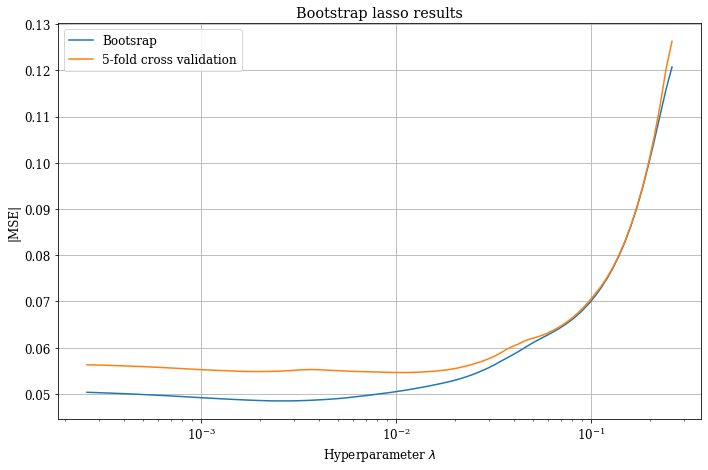

<IPython.core.display.Javascript object>

In [13]:
# Fixing font sizes of plots
fonts = {
    "font.family": "serif",
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
}

plt.rcParams.update(fonts)

# Log plot
plt.figure(figsize=(10, 6.7))
plt.semilogx(lambdas_lasso_bootstrap, mses_lasso_bootstrap, label="Bootsrap")
plt.semilogx(lambdas_lasso_cv, mses_lasso_cv, label="5-fold cross validation")
plt.xlabel(r"Hyperparameter $\lambda$")
plt.ylabel(r"|MSE|")
plt.title("Bootstrap lasso results")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Bootstrap and cross validation seem to estimate the error quite similarily. CV is probably a bit more realistic, as the error is a bit higher, but that i not important. The important thing is where the minimum is, and it seems to be almost the same for both methods.

# Task 1.5

To determine which features are nonlinear, I plot them all:

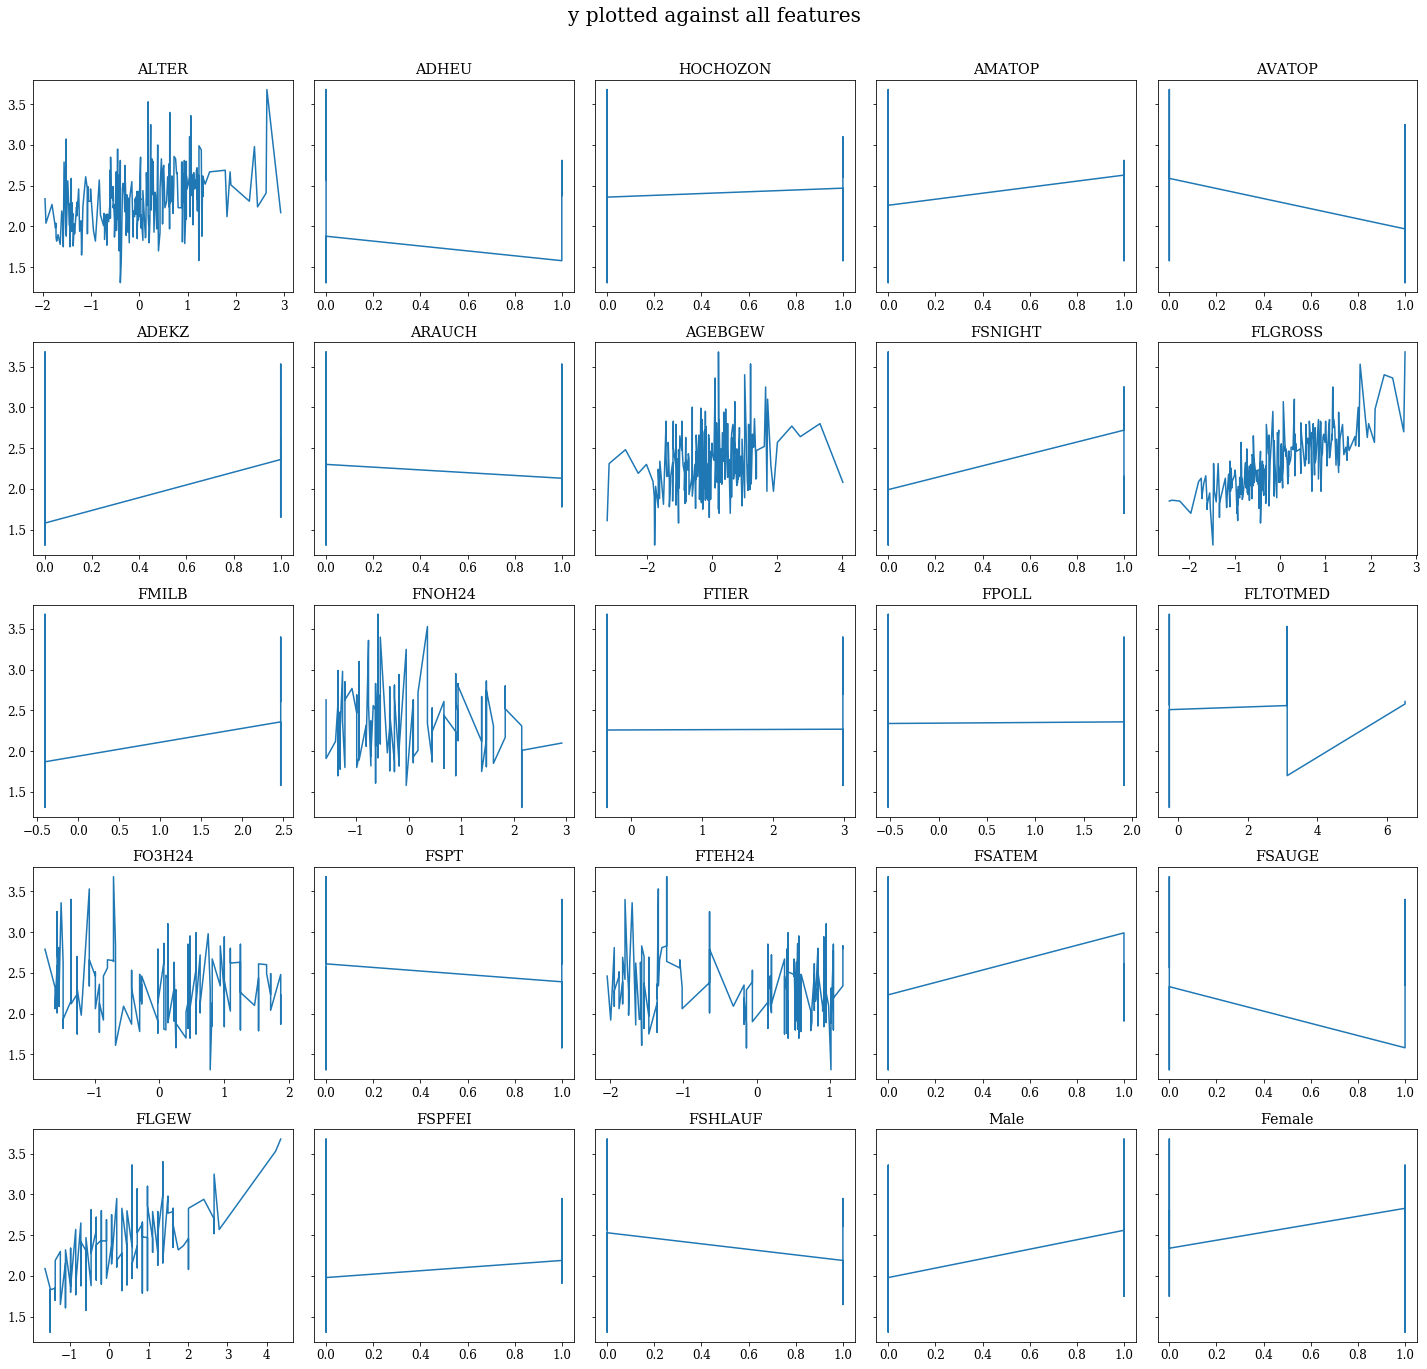

<IPython.core.display.Javascript object>

In [14]:
fig, axes = plt.subplots(5, 5, figsize=[20, 20], sharey=True)
axes = axes.ravel()
for i in range(X_train.values.shape[1]):
    sorted_indices = np.argsort(X_train.values[:, i])
    y_train.values[sorted_indices]
    axes[i].plot(X_train.values[:, i][sorted_indices], y_train.values[sorted_indices])
    axes[i].set_title(X_train.columns.values[i])
fig.suptitle("y plotted against all features", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

FLGEW, FTEH24 and AGEBGEW to me seem nonlinear.

In [15]:
i  # Splines and betas. pygam.s is a spline, pyham.l is a linear feature.
features_gam = pygam.l(0)

nonlinear_features = ["FLGEW", "FTEH24", "AGEBGEW"]

# Setting up splines for all categorical values.
for i, feature in enumerate(X_train.columns.values[1:]):
    if feature in nonlinear_features:
        features_gam += pygam.l(i) + pygam.s(i)
    else:
        features_gam += pygam.l(i)

# Lambdas for ramdomized search of penalties.
lambdas = np.exp(np.random.rand(100, len(features_gam)) * 3 - 3)
# Fitting a GAM-model and searching for best hyperparameters lambda
gam = pygam.LinearGAM(features_gam).gridsearch(
    X_train.values, y_train.values, lam=lambdas
)

100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11


<IPython.core.display.Javascript object>

In [16]:
# R^2 score. There was a bug with pygam so I had to calculate it like this.
r2_test_gam = gam._estimate_r2(X_test, y_test)["explained_deviance"]
r2_train_gam = gam._estimate_r2(X_train, y_train)["explained_deviance"]
print(f"R^2 score test: {r2_test_gam:.2f}, R^2 score train: {r2_train_gam:.2f}")

R^2 score test: 0.60, R^2 score train: 0.66


<IPython.core.display.Javascript object>

This seems to make no improvement. I am wondering if something is implemented wrongly or if this was to be expected. 
Could perheps try many more penalties. The increased complexity may have lead to overfitting as seen on the difference between train and test $R^2$.

Next I test with adding higher orders of the nonlinear features.

In [17]:
# Reversing scale of training features, need this to get the second order features. Will scale them again after.
X_train_nonlinear = scaler.inverse_transform(
    X_train.loc[:, np.logical_not(np.isin(X_train.columns, categorical))]
)
# Reversing scale of testing features, need this to get the second order features. Will scale them again after.
X_test_nonlinear = scaler.inverse_transform(
    X_test.loc[:, np.logical_not(np.isin(X_test.columns, categorical))]
)
# Lists to save the nonlinear features and names
nonlinear_columns_train = []
nonlinear_columns_test = []
nonlinear_columns_name = []
# Looping over features
for i, name in enumerate(
    X_train.loc[:, np.logical_not(np.isin(X_train.columns, categorical))]
):
    # If feature is in nonlinear_features, add it to list of nonlinear features
    if name in nonlinear_features:
        nonlinear_columns_train.append(X_train_nonlinear[:, i] ** 2)
        nonlinear_columns_test.append(X_test_nonlinear[:, i] ** 2)
        nonlinear_columns_name.append(name + "^2")
# Creating columns with right dimensions out of second order features
nonlinear_columns_train = np.array(nonlinear_columns_train).T
nonlinear_columns_test = np.array(nonlinear_columns_test).T
# Scaling the nonlinear features
scaler_nonlinear = sklpre.StandardScaler()
nonlinear_columns_train = scaler_nonlinear.fit_transform(nonlinear_columns_train)
nonlinear_columns_test = scaler_nonlinear.transform(nonlinear_columns_test)
# Creating new dataframes containing the nonlinear features
X_train_nonlinear = pd.DataFrame(
    nonlinear_columns_train, columns=nonlinear_columns_name, index=X_train.index.values
)
X_test_nonlinear = pd.DataFrame(
    nonlinear_columns_test, columns=nonlinear_columns_name, index=X_test.index.values
)
# Creating new dataframes with all features, ready for fit
X_train_nonlinear = X_train.join(X_train_nonlinear)
X_test_nonlinear = X_test.join(X_test_nonlinear)

# Fitting OLS model
regressor_nonlinear = skllm.LinearRegression().fit(X_train_nonlinear, y_train)

# R2 scores
r2_score_nonlinear_train = regressor_nonlinear.score(X_train_nonlinear, y_train)
r2_score_nonlinear_test = regressor_nonlinear.score(X_test_nonlinear, y_test)
print(
    f"R2 score test:{r2_score_nonlinear_test:.2f}, train: {r2_score_nonlinear_train:.2f}"
)
# Printing table of p-values etc.
get_summary_linear_model(regressor_nonlinear, X_train_nonlinear, y_train)

R2 score test:0.58, train: 0.67


,Feature,$\beta_i$,$\pm$,p-values
0,Intercept,2.334888,0.027789,0.000000e+00
1,ALTER,0.001525,0.017421,9.303320e-01
2,ADHEU,-0.143088,0.081172,7.917633e-02
3,HOCHOZON,-0.050491,0.042714,2.383160e-01
4,AMATOP,-0.044812,0.037981,2.391988e-01
5,AVATOP,-0.040621,0.036988,2.731726e-01
6,ADEKZ,0.053986,0.038059,1.573043e-01
7,ARAUCH,0.020233,0.033452,5.458354e-01
8,AGEBGEW,0.147102,0.116830,2.091776e-01
9,FSNIGHT,0.014734,0.051801,7.763192e-01


<IPython.core.display.Javascript object>

Seems to perform about equally to the GAM model. As we can see the p-values aren't very impressive for the new nonlinear features. They also have rather high uncertainties.

# Task 1.6
I can't find an implementation of component-wise boosting, so I will load R into my notebook and try my best there! I feel like R still has many more features than Python when it comes to lesser known statistical learning methods, so I think it is still good to learn the best of both worlds.

In [5]:
%load_ext rpy2.ipython
train_for_r = X_train.join(y_train)
test_for_r = X_test.join(y_test)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


<IPython.core.display.Javascript object>

First I fit a component_wise boost with splines!

In [19]:
%%R -i train_for_r -i test_for_r
library(compboost)
library(ggplot2)
spline_boost = boostSplines(data = train_for_r, target = "FFVC", loss = LossQuadratic$new(), trace=10)

  1/100: risk = 0.06
 10/100: risk = 0.041
 20/100: risk = 0.032
 30/100: risk = 0.028
 40/100: risk = 0.026
 50/100: risk = 0.024
 60/100: risk = 0.023
 70/100: risk = 0.022
 80/100: risk = 0.021
 90/100: risk = 0.021
100/100: risk = 0.02


Train 100 iterations in 0 Seconds.
Final risk based on the train set: 0.02



<IPython.core.display.Javascript object>

In [20]:
%%R
table(spline_boost$getSelectedBaselearner())


AGEBGEW_spline   ALTER_spline   FLGEW_spline FLGROSS_spline   FMILB_spline 
             5              5             18             31              1 
 FO3H24_spline  FSPFEI_spline  FTEH24_spline  Female_spline    Male_spline 
             6              3             16             11              4 


<IPython.core.display.Javascript object>

As we can see, not all features are chosen. The FLGROSS is chosen the most, which makes sense, as it had the lowest p-value in our original OLS model as well. 

Next I will do the same for linear regressors.

In [36]:
%%R
linear_boost = boostLinear(data = train_for_r, target = "FFVC", loss = LossQuadratic$new(), trace=10)

  1/100: risk = 0.061
 10/100: risk = 0.042
 20/100: risk = 0.034
 30/100: risk = 0.031
 40/100: risk = 0.028
 50/100: risk = 0.027
 60/100: risk = 0.026
 70/100: risk = 0.026
 80/100: risk = 0.025
 90/100: risk = 0.025
100/100: risk = 0.024


Train 100 iterations in 0 Seconds.
Final risk based on the train set: 0.024



<IPython.core.display.Javascript object>

In [22]:
%%R
linear_boost$getEstimatedCoef()

$AGEBGEW_linear
             [,1]
[1,] 5.342005e-05
[2,] 8.914959e-04

$ALTER_linear
            [,1]
[1,] 0.003361453
[2,] 0.020417242

$FLGEW_linear
           [,1]
[1,] 0.01683412
[2,] 0.09495786

$FLGROSS_linear
           [,1]
[1,] 0.03202535
[2,] 0.17075866

$FLTOTMED_linear
              [,1]
[1,]  0.0001780553
[2,] -0.0007230610

$FSPFEI_linear
              [,1]
[1,] -0.0008423204
[2,]  0.0122879683

$Female_linear
            [,1]
[1,]  0.09257675
[2,] -0.18818881

$offset
[1] 2.243065



<IPython.core.display.Javascript object>

More or less the same features seem to be selected here as well. FLGROSS having the largest coefficient (Male and female have higher, but they are binary and therefore act differently.)

I didn't manage to get component-wise boosted trees working, sorry!

# Task 1.7

Calculating the train and test MSE for all models:

In [23]:
def mean_squared_error(sklearn_model, X, y):
    """
    Function for computing MSE of scikit-learn models.
    """
    return ((sklearn_model.predict(X) - y) ** 2).mean()

<IPython.core.display.Javascript object>

In [24]:
# MSE train and test of OLS
print(
    f"OLS: train: {mean_squared_error(ols_reg, X_train, y_train):g}"
    + f"  test: {mean_squared_error(ols_reg, X_test, y_test):g}"
)
# MSE train and test of strict forward selection
print(
    f"Increased: train: {mean_squared_error(regressor_increased, X_increased_train, y_train):g}"
    + f"  test: {mean_squared_error(regressor_increased, X_increased_test, y_test):g}"
)
# MSE train and test of less strict forward selection
print(
    f"Increased less strict: train: {mean_squared_error(regressor_increased_less_strict, X_increased_train_less_strict, y_train):g}"
    + f"  test: {mean_squared_error(regressor_increased_less_strict, X_increased_test_less_strict, y_test):g}"
)
# MSE train and test of strict backward elimination
print(
    f"Reduced: train: {mean_squared_error(regressor_reduced, X_reduce_train, y_train):g}"
    + f"  test: {mean_squared_error(regressor_reduced, X_reduce_test, y_test):g}"
)
# MSE train and test of less strict backward elimination
print(
    f"Reduced less strict: train: {mean_squared_error(regressor_reduced_less_strict, X_reduce_train_less_strict, y_train):g}"
    + f"  test: {mean_squared_error(regressor_reduced_less_strict, X_reduce_test_less_strict, y_test):g}"
)
# MSE train and test for LASSO CV
print(
    f"LASSO CV: train: {mean_squared_error(lasso_cv, X_train, y_train):g}"
    + f"  test: {mean_squared_error(lasso_cv, X_test, y_test):g}"
)
# MSE train and test for LASSO bootstrap
print(
    f"LASSO bootstrap: train: {mean_squared_error(lasso_bootstrap, X_train, y_train):g}"
    + f"  test: {mean_squared_error(lasso_bootstrap, X_test, y_test):g}"
)
# MSE train and test for GAM
print(
    f"GAM: train: {mean_squared_error(gam, X_train, y_train):g}"
    + f"  test: {mean_squared_error(gam, X_test, y_test):g}"
)

OLS: train: 0.0428674  test: 0.0482688
Increased: train: 0.04865  test: 0.0420083
Increased less strict: train: 0.04865  test: 0.0420083
Reduced: train: 0.0470368  test: 0.044036
Reduced less strict: train: 0.0443745  test: 0.0451905
LASSO CV: train: 0.048943  test: 0.0445636
LASSO bootstrap: train: 0.0438165  test: 0.0442285
GAM: train: 0.0428996  test: 0.0472678


<IPython.core.display.Javascript object>

In [38]:
%%R
library(MLmetrics)
print("Element-wise spline boosting:")
print("Train: ")
print(MSE(y_pred=data.matrix(spline_boost$predict(train_for_r)), y_true=data.matrix(train_for_r["FFVC"])))
print("Test: ")
print("N/A")
# The commented line under crashes everything!
#print(MSE(y_pred=data.matrix(spline_boost$predict(test_for_r)), y_true=data.matrix(test_for_r["FFVC"])))

print("Element-wise linear boosting:")
print("Train: ")
print(MSE(y_pred=data.matrix(linear_boost$predict(train_for_r)), y_true=data.matrix(train_for_r["FFVC"])))
print("Test: ")
print(MSE(y_pred=data.matrix(linear_boost$predict(test_for_r)), y_true=data.matrix(test_for_r["FFVC"])))

[1] "Element-wise spline boosting:"
[1] "Train: "
[1] 0.0408432
[1] "Test: "
[1] "N/A"
[1] "Element-wise linear boosting:"
[1] "Train: "
[1] 0.04892773
[1] "Test: "
[1] 0.04453509


<IPython.core.display.Javascript object>

Unfortunately compboost crashes when I try to use it to predict with data different from what it was fit on. Makes no sense if you ask me, but therefore I couldn't get it to print the test MSE.

The best model actually seems to be the forward selected OLS, surprisingly!

# Task 2.1

In [6]:
# Using R only for the lines with %R.
%R library(mlbench)
# Loading dataframe
%R data(PimaIndiansDiabetes)
# Now saving the dataframe in a Pandas dataframe in Python instead.
# This is actually really cool, just found out how to do it. Using
# Python together with R this way is probably very useful in data science!
df_2 = %R PimaIndiansDiabetes
X_2 = df_2.loc[:, df_2.columns != "diabetes"]
y_2 = df_2["diabetes"]
y_2 = (y_2.values == "neg").astype(np.int)
y_2 = pd.DataFrame(y_2, columns=["diabetes"])
X_train_2, X_test_2, y_train_2, y_test_2 = sklms.train_test_split(
    X_2, y_2, stratify=y_2, test_size=0.33
)
scaler_2 = sklpre.StandardScaler()
X_train_2 = pd.DataFrame(scaler_2.fit_transform(X_train_2), columns=X_train_2.columns)
X_test_2 = pd.DataFrame(scaler_2.transform(X_test_2), columns=X_test_2.columns)

<IPython.core.display.Javascript object>

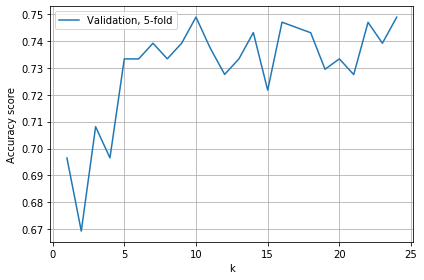

<IPython.core.display.Javascript object>

In [7]:
base_knn = sklne.KNeighborsClassifier()
k_grid = np.arange(1, 25)
hyperparams = {"n_neighbors": k_grid}
grid_search_knn_5_fold = sklms.GridSearchCV(
    base_knn, param_grid=hyperparams, cv=5, iid=False
)
grid_search_knn_5_fold.fit(
    X_train_2.values, y_train_2.values.ravel(),
)
fig, ax = plt.subplots()
ax.plot(
    k_grid,
    grid_search_knn_5_fold.cv_results_["mean_test_score"],
    label="Validation, 5-fold",
)
ax.grid()
ax.set_xlabel("k")
ax.set_ylabel("Accuracy score")
ax.legend()
fig.tight_layout()
plt.show()